# Lezione 11

In [ ]:
from liblet import (
  Grammar, 
  Derivation, 
  ProductionGraph,
  TopDownInstantaneousDescription,
  Table,
  Tree,
  closure, 
  warn, 
  show_calls, 
  union_of, 
  suffixes,
  ε, HASH,
)

La necessità di seguire tutti i possibili cammini nel grafo che simula la computazione del NPDA deriva dal fatto che (tra l'altro), per un certo simbolo $A$ in cima alla pila e il primo terminale $a$ non ancora elaborato, ci sono più produzioni da considerare.

Cominciamo a considerare alcune restrizioni sulla grammatica che potrebbero semplificarci la vita. Dapprima assumiamo che non ci siano ε-regole. Quindi immaginiamo che la grammatica sia tale per cui possiamo pre-computare una tabella che, in posizione $(A, a)$ indichi una sola produzione possibile.

In tal caso il processo di parsing si semplificherebbe come segue:

In [ ]:
def parse_noε(G, TABLE, INPUT):
  tdid = TopDownInstantaneousDescription(G, INPUT)
  while not tdid.is_done():
    if tdid.top() in G.N:
      P = TABLE[tdid.top(), tdid.head()]
      if P is None:
        warn(f'No production for ({tdid.top()}, {tdid.head()}) at {tdid.steps}')
        return None 
      tdid = tdid.predict(P)
    else:
      if tdid.top() == tdid.head():
        tdid = tdid.match()
      else:
        warn(f'Expecting {tdid.top()}, got {tdid.head()}')
        return None   
  return Derivation(G).leftmost(tdid.steps)

Ma come costruire `TABLE`?

## Caso SLL(1)

Se la grammatica è tale per cui, per ciascun non terminale, le sue alternative iniziano tutte con terminali distinti, è molto facile!

In [ ]:
# fig. 8.4. pag. 238

G = Grammar.from_string("""
S -> a B
B -> b | a B b
""")
G

Grammar(N={B, S}, T={a, b}, P=(S -> a B, B -> b, B -> a B b), S=S)

In [ ]:
def compute_simple_table(G):

  TABLE = Table(2, no_reassign = True)

  for P in G.P:
    A, (a, *α) = P
    TABLE[A, a] = P

  return TABLE

Qui si usa un oggetto `Table`, il valore `2` indica che la tabella ha dimensione 2, ossia ha righe e colonne…


In [ ]:
TABLE = compute_simple_table(G)
TABLE

In [ ]:
d = parse_noε(G, TABLE, list('aabb'))
d

S -> a B -> a a B b -> a a b b

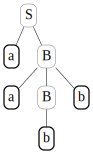

In [ ]:
ProductionGraph(d)

Possono accadere due errori di parsing… o perché manca una produzione adatta, o perché l'ultima produzione utilizzata comporta che l'algoritmo si aspetti un carattere che manca nell'input…

In [ ]:
parse_noε(G, TABLE, list('aac'))

No production for (B, c) at (S -> a B, B -> a B b)


In [ ]:
parse_noε(G, TABLE, list('aabc'))

Expecting b, got c


### E se non è "semplice"?

La costruzione della tabella è in grado, di accorgersi che stiamo tentando di assegnare di nuovo un valore per un certo $(A, a)$… (si tratta del parametro `no_reassign = True` usato nella costruzione di `Table`).

In [ ]:
# fig. 8.1, pag. 236

G = Grammar.from_string("""
S -> a B | b A
A -> a | a S | b A A
B -> b | b S | a B B
""")

In [ ]:
compute_simple_table(G)

Table already contains value A -> a for (A, a)
Table already contains value B -> b for (B, b)


### Un esempio più naturale: notazione prefissa

Torniamo a consideare una grammatica SLL(1) forse più naturale della prima da cui siamo partiti: una grammatica per operazioni aritmetiche in [notazione polacca](https://en.wikipedia.org/wiki/Polish_notation).

In [ ]:
G = Grammar.from_string("""
E -> + E E | - E E | * E E | / E E | t
""")
G

Grammar(N={E}, T={*, +, -, /, t}, P=(E -> + E E, E -> - E E, E -> * E E, E -> / E E, E -> t), S=E)

In [ ]:
TABLE = compute_simple_table(G)
TABLE

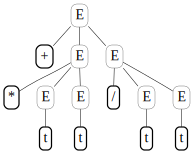

In [ ]:
ProductionGraph(parse_noε(G, TABLE, '+ * t t / t t'.split()))

#### <span style="color: red;">Esercizio per casa</span>

Sapreste modificare `parse_noε` perché restituisca, invece della derivazione, il valore dell'espressione aritmetica? Sapreste integrarlo con un tokenizzatore che consenta di sostiuire numeri interi al terminale `t`?

Saprese trasformare gli alberi prodotti da `parse_noε` in modo che nodi siano operandi o opreatori, come nell'esempio seguente?

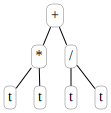

In [ ]:
Tree.from_lol(['+', ['*', ['t'], ['t']], ['/', ['t'], ['t']]])

## Caso LL(1) (senza ε-regole), gli insiemi `FIRST` 

Se la grammatica non è "semplice" il caso non è disperato (almeno se non ci sono ε-regole). 

Supponiamo di conoscere, per ogni forma sentenziale $\omega$, qual'è il primo terminale $t$ che (eventualmente) produrrà; detto in formule, supponiamo di conoscere l'insieme $\operatorname{FIRST}(\omega) = \{ t \in T \mid \omega\overset{*}{\to} t\gamma, \gamma\in (N\cup T)^* \}$. 

Allora potremmo determinare `TABLE` come segue:

In [ ]:
def compute_table(G):

  TABLE = Table(2, no_reassign = True)

  FIRST = compute_first(G)

  for P in G.P:
    A, (B, *β) = P # questo significa che la produzione P ha la forma A -> Bβ con β eventualmente nulla
    for a in FIRST[B]: # scegliamo P sulla base del fatto che Bβ deriva a
      TABLE[A, a] = P

  return TABLE

Osservate che, data la produzione $A\to B\beta$ (con $\beta$ eventualmente vuota), invece di usare $\operatorname{FIRST}(B\beta)$ ci siamo contentati di $\operatorname{FIRST}(B)$ dal momento che (in assenza di ε-regole) evidentemente se $B\beta\overset{*}{\to} t\gamma$ allora $B\overset{*}{\to} t\gamma'$ (dove $\gamma'$ è un prefisso di $\gamma$).

Inoltre, la definizione di $\operatorname{FIRST}$ suggerisce un semplice modo ricorsivo per calcolare $\operatorname{FIRST}(X)$:

* se $X\in T$ allora per forza $\operatorname{FIRST}(X) = \{X\}$;
* viceversa $\operatorname{FIRST}(X)$ sarà dato dall'unione di tutti i $\operatorname{FIRST}(Y)$ per tutti gli $Y \neq X$ tali che $X\to Y\alpha$.

In [ ]:
def compute_first(G):

  def recursive_first(X): # X è G.T | G.N
    return union_of(
      recursive_first(Y)
      for Y, *α in G.alternatives(X) if Y != X # occhio alla ricorsione a sinistra!
    ) if X in G.N else {X}
  
  FIRST = Table(1)
  for X in G.N | G.T: FIRST[X] = recursive_first(X)
      
  return FIRST

Proviamo cosa accade con questa grammatica

In [ ]:
# fig. 8.7, pag. 240

G = Grammar.from_string("""
Session -> Fact Session | Question
Session -> ( Session ) Session
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Fact Session, Session -> Question, Session -> ( Session ) Session, Fact -> ! STRING, Question -> ? STRING), S=Session)

In [ ]:
FIRST = compute_first(G)
FIRST.restrict_to(G.N) # ci interessano solo le righe relative ai non terminali

Correttamente, il non terminale `Session` può produrre parole che iniziano con `!`, `?` oppure `(`. Ora calcoliamo `TABLE` 

In [ ]:
TABLE = compute_table(G)
TABLE

Ora possiamo usare esattamente lo stesso `parse_noε`, passando questa tabella, per derivare una parola

In [ ]:
INPUT = '! STRING ! STRING ? STRING'.split()

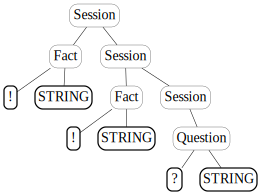

In [ ]:
ProductionGraph(parse_noε(G, TABLE, INPUT))

## Cosa accade con le ε-regole? 

Consideriamo la seguente versione più "naturale" della precedente grammatica:

In [ ]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Facts, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Facts Question, Session -> ( Session ) Session, Facts -> Fact Facts, Facts -> ε, Fact -> ! STRING, Question -> ? STRING), S=Session)

### Estendere il calcolo di `FIRST` al caso con ε-regole

Evidentemente non potremo più semplificarci la vita considerando $\operatorname{FIRST}(B\beta) = \operatorname{FIRST}(B)$, perché se $B\to\varepsilon$ (altrimenti detto $\varepsilon\in \operatorname{FIRST}(B)$) per prima cosa non è detto che $\varepsilon\in \operatorname{FIRST}(B\beta)$ (perché potrebbe essere che $\varepsilon\not\in \operatorname{FIRST}(\beta)$), ma sopratutto dovremo aggiungere anche $\operatorname{FIRST}(\beta)$ a $\operatorname{FIRST}(B\beta)$ per tenere conto del caso in cui la prima produzione sia proprio quella che "fa sparire" $B$! 

Siamo pronti per aggiornare il calcolo di $\operatorname{FIRST}(\omega)$, questa volta per semplificarci la vita useremo una chiusura; gli elementi della tabella `FIRST` saranno insiemi ai quali, ad ogni passo della chiusura, aggiungeremo i terminali che di volta in volta individueremo come i primi derivabili da $\omega$.

Inizialmente $\operatorname{FIRST}(t) = \{t\}$ per tutti i $t \in T \cup \{\varepsilon, \#\}$. Poi ad ogni passo della chiusura aggiorneremo `FIRST` seceondo questa logica:

* considerando le produzioni $X\to \alpha$, estenderemo $\operatorname{FIRST}(X)$ in modo che contenga 
  $\operatorname{FIRST}(\alpha)$ (come fatto nel caso senza ε-regole );
* inoltre, al fine di tener conto del fatto che i prefissi di $\alpha$ potrebbero produrre $\varepsilon$, 
  considereremo anche tutti i suffissi $\gamma = A\beta$ di $\alpha$, estendendo $\operatorname{FIRST}(\gamma)$
  in modo che contenga:
    * $\operatorname{FIRST}(A)$ (tranne eventualmente $\varepsilon$, che non va aggiunto a meno che 
      $\beta\overset{*}{\to} \varepsilon$) e
    * $\operatorname{FIRST}(\beta)$ se $\varepsilon\in \operatorname{FIRST}(A)$.

Possiamo procurarci i suffissi di una forma sentenziale con la seguente funzione

In [ ]:
list(suffixes('example'))

['example', 'xample', 'ample', 'mple', 'ple', 'le', 'e']

In [ ]:
def compute_εfirst(G):

  FIRST = Table(1, element = set) # questo significa che gli elementi dell tabella sono insiemi

  # per prima cosa, il caso banele 
  for t in G.T: FIRST[(t, )] = {t} # attenzione, gli indici sono forme sentenziali, ossia tuple!

  # qualche caso "extra" che ci verrà comodo poi    
  FIRST[tuple()] = {ε}
  FIRST[(ε, )] = {ε}
  FIRST[(HASH, )] = {HASH}

  @closure
  def update_with_suffixes(FIRST):
    for X, α in G.P:
      FIRST[(X, )] |= FIRST[α]
      for γ in suffixes(α):
        A, *β = γ
        FIRST[γ] |= FIRST[(A, )] - {ε}
        if ε in FIRST[(A, )]: FIRST[γ] |= FIRST[β]
    return FIRST

  return update_with_suffixes(FIRST)

In [ ]:
FIRST = compute_εfirst(G)
FIRST.restrict_to({(X, ) for X in G.N})

Quanto ottenuto fin qui è corretto, ma `FIRST` contiene valori solo per certe forme sentenziali (ottenute come suffissi dei lati destri), non per tutte. Non è però difficile estenderlo in modo che funzioni in generale.

Ragionando in maniera ricorsiva (come abbiamo fatto in `compute_first`) è possibile passare da un insieme ad una funzione `FIRSTf` che calcoli $\operatorname{FIRST}(\omega)$ qualunque sia $\omega$

In [ ]:
def make_first_function(G):

  FIRST = compute_εfirst(G)

  @show_calls(True)
  def FIRSTf(ω):
    if not ω: return {ε}
    X, *γ = ω
    fx = FIRST[(X, )]
    if ε in fx:
      return (fx - {ε}) | FIRSTf(γ)
    else:
      return fx

  return FIRSTf

Possiamo provarla su una forma addirittura non derivabile da $S$

In [ ]:
FIRSTf = make_first_function(G)

In [ ]:
FIRSTf(('Facts', 'Facts', 'Question', HASH ))

┌FIRSTf(('Facts', 'Facts', 'Question', '♯'))
│┌FIRSTf(['Facts', 'Question', '♯'])
││┌FIRSTf(['Question', '♯'])
││└─ {'?'}
│└─ {'!', '?'}
└─ {'!', '?'}


{'!', '?'}

Ora la nostra speranza è poter calcolare `TABLE` a partire da `FRISTf`, ma purtroppo è impossibile auspicarsi di poter decidere che produzione usare considerando solo il simbolo $A$ in cima alla pila, dato che potrebbe darsi il caso che $A\to\varepsilon$.